## Playground for MDP (openai gym)

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# Types
from gym import Env

# Time helpers
from timeit import default_timer as timer

In [2]:
# Some colors for plots
one = mpatches.Patch(facecolor='#f3f300', label='label1', linewidth = 0.5, edgecolor = 'black')
two = mpatches.Patch(facecolor='#ff9700', label = 'label2', linewidth = 0.5, edgecolor = 'black')
three = mpatches.Patch(facecolor='#ff0000', label = 'label3', linewidth = 0.5, edgecolor = 'black')

## Policy iteration

In [27]:
# Standard values
MAX_ITER = 5e5
GAMMA = 0.9
EPS = 1e-5

In [4]:
def sum_sr(env: Env, V: np.ndarray, s: int, a: int):
    tmp = 0
    for p, s_, r, _ in env.P[s][a]:
        tmp += p * (r + GAMMA * V[s_])
    return tmp

In [5]:
def standard_pi(env: Env):
    """
        Naive: Policy Iteration Algorithm
    """
    
    V = np.zeros(env.observation_space.n)
    pi = np.zeros(env.observation_space.n, dtype=int)  # greedy, always pick action 0
    
    itertations_counter = 0
    while itertations_counter < MAX_ITER:
        while True:
            delta = 0
            
            for s in range(env.observation_space.n):
                itertations_counter += 1
                v = V[s]
                V[s] = sum_sr(env, V=V, s=s, a=pi[s])
                delta = max(delta, abs(v - V[s]))
                
            if delta < EPS: 
                break
                
        policy_stable = True
        for s in range(env.observation_space.n):
            old_action = pi[s]
            
            pi[s] = np.argmax([sum_sr(env, V=V, s=s, a=a)  for a in range(env.action_space.n)])
            
            if old_action != pi[s]: 
                policy_stable = False
                
        if policy_stable: 
            break
    
    print("Total iterations spent: {}".format(itertations_counter))
    return V, pi

## Value iteration
In value iteration, we do not run policy evaluation to completion. We perform just one sweep over all the states and act greedily with current value function.

In [6]:
def extract_arg_max(env: Env, V: np.ndarray, pi: np.ndarray, action: int, s: int):
    e = np.zeros(env.action_space.n)
    
    for a in range(env.action_space.n):                         # iterate for every action possible 
        q=0
        P = np.array(env.P[s][a])                   
        (x,y) = np.shape(P)                             # for Bellman Equation 
        
        for i in range(x):                              # iterate for every possible states
            s_= int(P[i][1])                            # S' - Sprime - possible succesor states
            p = P[i][0]                                 # Transition Probability P(s'|s,a) 
            r = P[i][2]                                 # Reward
            
            q += p * (r + GAMMA * V[s_])                      # calculate action_ value q(s|a)
            e[a] = q
            
    m = np.argmax(e) 
    action[s]=m                                           # Take index which has maximum value 
    pi[s][m] = 1                                        # update pi(a|s) 

    return pi


## Bellman optimality computation

In [7]:
def bellman_optimality(env: Env, V: np.ndarray, s: int):
    pi = np.zeros((env.observation_space.n, env.action_space.n))
    e = np.zeros(env.action_space.n)
    
    for a in range(env.action_space.n):
        q = 0
        P = np.array(env.P[s][a])
        (x, y) = P.shape
        for i in range(x):
            s_= int(P[i][1])
            p = P[i][0]
            r = P[i][2]
            q += p * (r + GAMMA * V[s_])
            e[a] = q
        
    m = np.argmax(e)
    pi[s][m] = 1
    
    value = 0
    for a in range(env.action_space.n):
        u = 0
        P = np.array(env.env.P[s][a])
        (x,y) = np.shape(P)
        for i in range(x):
            
            s_= int(P[i][1])
            p = P[i][0]
            r = P[i][2]
            
            u += p * (r + GAMMA * V[s_])
            
        value += pi[s,a] * u
  
    V[s] = value
    
    return V[s]
        
    

In [8]:
def standard_vi(env: Env):
    """
        Naive: Value Iteration Algorithm
    """
    V = np.zeros(env.observation_space.n)
    iterations_counter = 0
    
    values_deltas = []
    while iterations_counter < MAX_ITER:
        delta = 0

        for s in range(env.observation_space.n):
            iterations_counter += 1
            v = V[s]
            V[s] = bellman_optimality(env=env, V=V, s=s)
            delta = max(delta, abs(v - V[s]))
            values_deltas.append(np.linalg.norm(v - V[s]))

        if delta < EPS: 
            break
    
    pi = np.zeros((env.observation_space.n, env.action_space.n)) 
    action = np.zeros((env.observation_space.n))
    for s in range(env.observation_space.n):
        pi = extract_arg_max(env=env, V=V, pi=pi, action=action, s=s)  # extract optimal policy using action value 
    
    print("Total iterations spent: {}".format(iterations_counter))
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot([i for i in range(iterations_counter)], values_deltas, label="||V_(k+1)(s) - V_k(s)||") # Or however the Axes was created.
    ax.legend()
    ax.get_legend().set_title("Standard Value iteration covergence")
    return V, pi, action

## Improved value iterations
- Gauss 
- Prioritised Sweeping


In [9]:
def bellman_optimality_gauss(env: Env, V: np.ndarray, s: int):
    pi = np.zeros((env.observation_space.n, env.action_space.n))
    e = np.zeros(env.action_space.n)
    
    for a in range(env.action_space.n):
        q = 0
        P = np.array(env.P[s][a])
        (x, y) = P.shape
        for i in range(x):
            
            s_= int(P[i][1])
            p = P[i][0]
            r = P[i][2]
            q += p * (r + GAMMA * V[s])
            e[a] = q
        
    m = np.argmax(e)
    pi[s][m] = 1.0  # Max probability for the best state
    
    value = 0
    for a in range(env.action_space.n):
        u = 0
        P = np.array(env.env.P[s][a])
        (x,y) = P.shape
        for i in range(x):
            
            s_= int(P[i][1])
            p = P[i][0]
            r = P[i][2]
            
            u += p * (r + GAMMA * V[s])
            
        value += pi[s,a] * u
  
    V[s] = value
    
    return V[s]

In [10]:
def gauss_vi(env: Env):
    V = np.zeros(env.observation_space.n)
    iterations_counter = 0
    
    values_deltas = []
    while iterations_counter < MAX_ITER:
        delta = 0

        for s in range(env.observation_space.n):
            iterations_counter += 1
            v = V[s]
            V[s] = bellman_optimality_gauss(env=env, V=V, s=s)
            delta = max(delta, abs(v - V[s]))
            values_deltas.append(np.linalg.norm(v - V[s]))

        if delta < EPS: 
            break
    
    pi = np.zeros((env.observation_space.n, env.action_space.n)) 
    action = np.zeros((env.observation_space.n))
    for s in range(env.observation_space.n):
        pi = extract_arg_max(env=env, V=V, pi=pi, action=action, s=s)  # extract optimal policy using action value 
    
    print("Total iterations spent in Gauss VI: {}".format(iterations_counter))
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot([i for i in range(iterations_counter)], values_deltas, label="||V_(k+1)(s) - V_k(s)||") # Or however the Axes was created.
    ax.legend()
    ax.get_legend().set_title("Gauss Seidel Value iteration covergence")
    
    return V, pi, action

## Priority

In [11]:
def ps_vi(env: Env):
    V = np.zeros(env.observation_space.n)
    H = np.zeros(env.observation_space.n)
    
    iterations_counter = 0
    
    values_deltas = []
    while iterations_counter < MAX_ITER:
        iterations_counter += 1
        delta = 0
        hp_s = np.argmax(H) # Highest priority state
        v = V[hp_s]
        
        V[hp_s] = bellman_optimality_gauss(env=env, V=V, s=hp_s)
        
        for _s in range(env.observation_space.n):
            if _s != hp_s:
                V[_s] = v
            
        for h in range(env.observation_space.n):
            H[h] = abs(bellman_optimality_gauss(env=env, V=V, s=h) - V[h])
        
        # Stability
        delta = max(delta, abs(v - V[hp_s]))
        values_deltas.append(np.linalg.norm(v - V[hp_s]))
        
        if delta < EPS:
            break
    
    pi = np.zeros((env.observation_space.n, env.action_space.n)) 
    action = np.zeros((env.observation_space.n))
    for s in range(env.observation_space.n):
        pi = extract_arg_max(env=env, V=V, pi=pi, action=action, s=s)  # extract optimal policy using action value 
    
    print("Total iterations spent in PS: {}".format(iterations_counter))
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot([i for i in range(iterations_counter)], values_deltas, label="||V_(k+1)(s) - V_k(s)||") # Or however the Axes was created.
    ax.legend()
    ax.get_legend().set_title("PS iteration covergence")
    
    return V, pi, action

## First evironment [ taxi-v3 ]

In [12]:
taxi_v3 = gym.make("Taxi-v3")

In [13]:
times = []
for _ in range(10):
    start = timer()
    V, pi = standard_pi(env=taxi_v3)
    end = timer()
    print("Total time spent {}s".format(end - start))
    times.append(end - start)

print("\n\t Average time per 10 runs: {}s".format(np.mean(np.array(times))))

Total iterations spent: 90500
Total time spent 0.5256671998649836s
Total iterations spent: 90500
Total time spent 0.5370845999568701s
Total iterations spent: 90500
Total time spent 0.5392771000042558s
Total iterations spent: 90500
Total time spent 0.5315815999638289s
Total iterations spent: 90500
Total time spent 0.5322914000134915s
Total iterations spent: 90500
Total time spent 0.5413641000632197s
Total iterations spent: 90500
Total time spent 0.5425181000027806s
Total iterations spent: 90500
Total time spent 0.5348048999439925s
Total iterations spent: 90500
Total time spent 0.5242184000089765s
Total iterations spent: 90500
Total time spent 0.5523867001757026s

	 Average time per 10 runs: 0.5361194099998101s


Total iterations spent: 26000
Total time spent 2.0157440998591483s


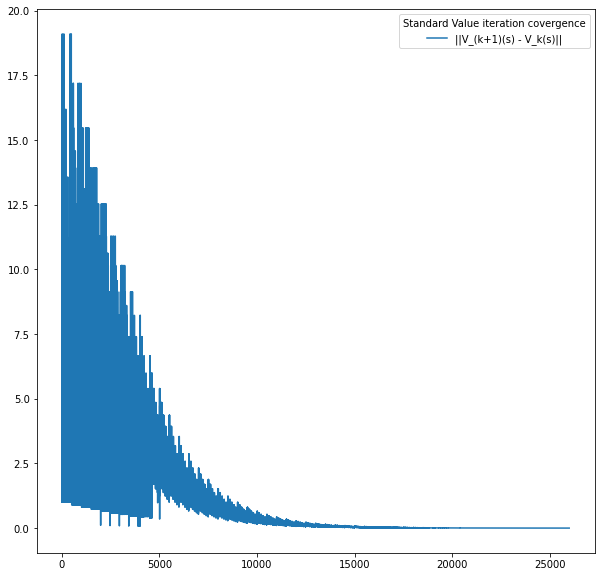

In [14]:
start = timer()
V, pi, _ = standard_vi(env=taxi_v3)
end = timer()
print("Total time spent {}s".format(end - start))

Total iterations spent in Gauss VI: 47500
Total time spent 3.4694868999067694s


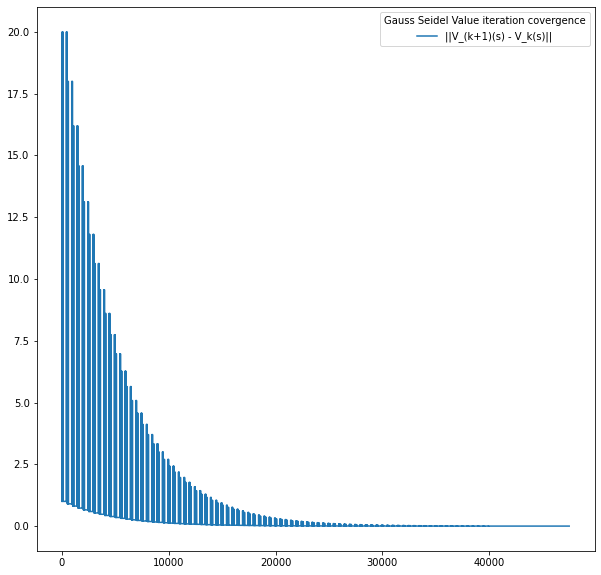

In [15]:
start = timer()
V, pi, _ = gauss_vi(env=taxi_v3)
end = timer()
print("Total time spent {}s".format(end - start))

Total iterations spent in PS: 37
Total time spent 1.3025829999241978s


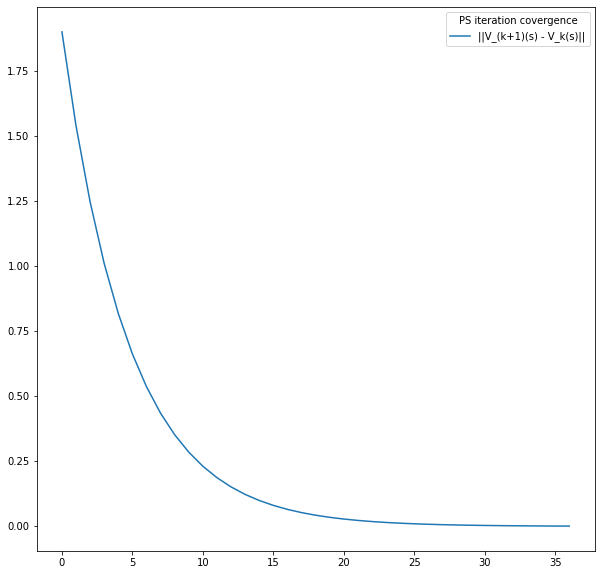

In [16]:
start = timer()
V, pi, _ = ps_vi(env=taxi_v3)
end = timer()
print("Total time spent {}s".format(end - start))

## Second environment [ frozen lake ]

In [17]:
frozen_lake = gym.make("FrozenLake-v1")

In [18]:
times = []
for _ in range(10):
    start = timer()
    V, pi = standard_pi(env=frozen_lake)
    end = timer()
    print("Total time spent {}s".format(end - start))
    times.append(end - start)

print("\n\t Average time per 10 runs: {}s".format(np.mean(np.array(times))))

Total iterations spent: 752
Total time spent 0.005368699785321951s
Total iterations spent: 752
Total time spent 0.005492000142112374s
Total iterations spent: 752
Total time spent 0.005441899877041578s
Total iterations spent: 752
Total time spent 0.005666299955919385s
Total iterations spent: 752
Total time spent 0.005486200097948313s
Total iterations spent: 752
Total time spent 0.006132300011813641s
Total iterations spent: 752
Total time spent 0.005474899895489216s
Total iterations spent: 752
Total time spent 0.00572929996997118s
Total iterations spent: 752
Total time spent 0.0054199001751840115s
Total iterations spent: 752
Total time spent 0.006392100127413869s

	 Average time per 10 runs: 0.005660360003821552s


Total iterations spent: 368
Total time spent 0.049604699946939945s


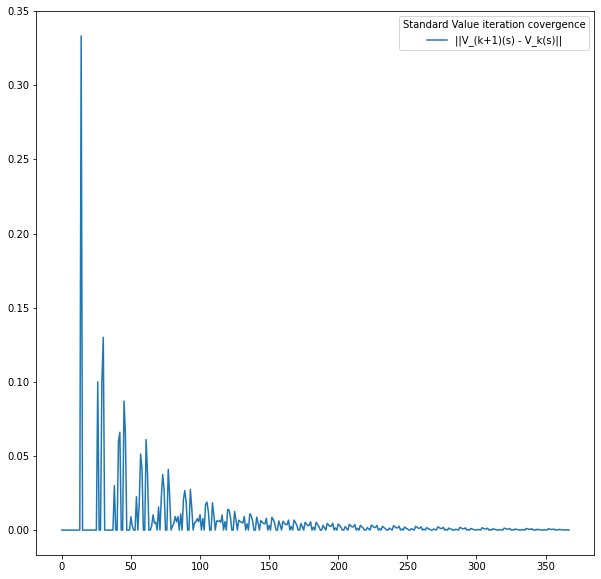

In [19]:
start = timer()
V, pi, _ = standard_vi(env=frozen_lake)
end = timer()
print("Total time spent {}s".format(end - start))

Total iterations spent in Gauss VI: 912
Total time spent 0.08640129980631173s


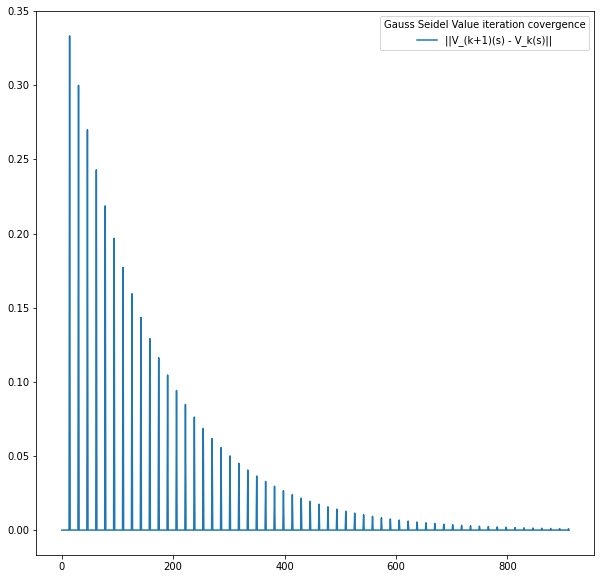

In [20]:
start = timer()
V, pi, _ = gauss_vi(env=frozen_lake)
end = timer()
print("Total time spent {}s".format(end - start))

Total iterations spent in PS: 1
Total time spent 0.016786100110039115s


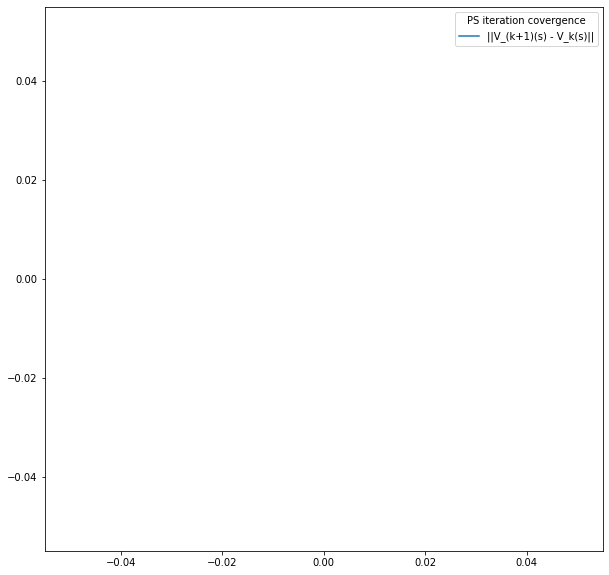

In [28]:
start = timer()
V, pi, _ = ps_vi(env=frozen_lake)
end = timer()
print("Total time spent {}s".format(end - start))

## Larger frozen lake [ 8 * 8 ]


In [22]:
frozen_lake_large = gym.make("FrozenLake8x8-v1")

In [23]:
times = []
for _ in range(10):
    start = timer()
    V, pi = standard_pi(env=frozen_lake_large)
    end = timer()
    print("Total time spent {}s".format(end - start))
    times.append(end - start)

print("\n\t Average time per 10 runs: {}s".format(np.mean(np.array(times))))

Total iterations spent: 4160
Total time spent 0.03544819983653724s
Total iterations spent: 4160
Total time spent 0.0346329000312835s
Total iterations spent: 4160
Total time spent 0.03441699990071356s
Total iterations spent: 4160
Total time spent 0.03426979994401336s
Total iterations spent: 4160
Total time spent 0.03646189998835325s
Total iterations spent: 4160
Total time spent 0.03369660000316799s
Total iterations spent: 4160
Total time spent 0.03418179997242987s
Total iterations spent: 4160
Total time spent 0.03407220006920397s
Total iterations spent: 4160
Total time spent 0.033610899932682514s
Total iterations spent: 4160
Total time spent 0.03367069992236793s

	 Average time per 10 runs: 0.03444619996007532s


Total iterations spent: 1536
Total time spent 0.1391150001436472s


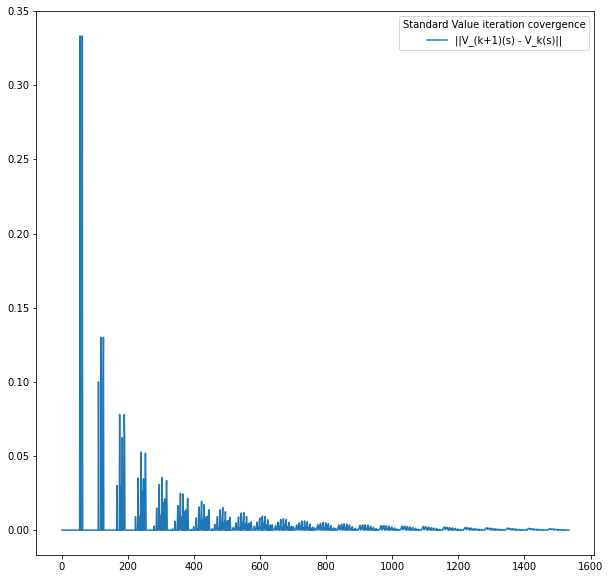

In [24]:
start = timer()
V, pi, _ = standard_vi(env=frozen_lake_large)
end = timer()
print("Total time spent {}s".format(end - start))

Total iterations spent in Gauss VI: 3648
Total time spent 0.29274659999646246s


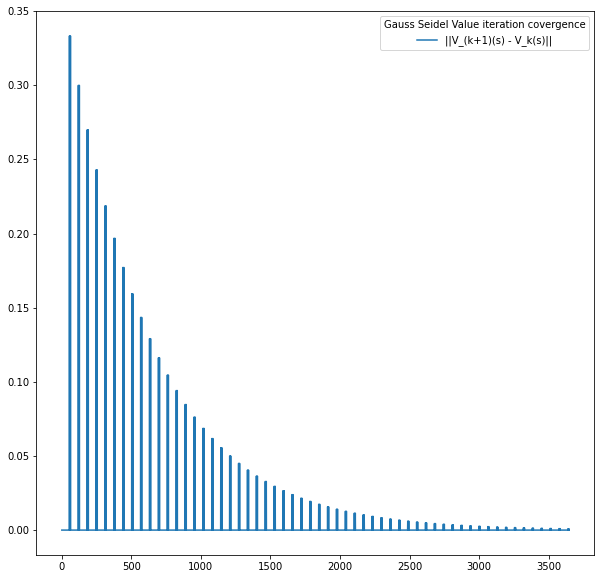

In [25]:
start = timer()
V, pi, _ = gauss_vi(env=frozen_lake_large)
end = timer()
print("Total time spent {}s".format(end - start))

Total iterations spent in PS: 1
Total time spent 0.023420300101861358s


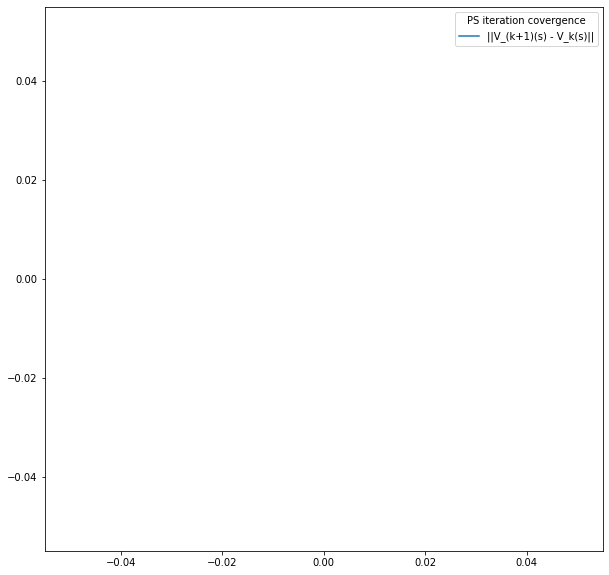

In [29]:
start = timer()
V, pi, _ = ps_vi(env=frozen_lake_large)
end = timer()
print("Total time spent {}s".format(end - start))